<a href="https://colab.research.google.com/github/erenkaynarr/aygaz-proje/blob/main/erenkaynar_derinogrenmeaygaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [2]:
from keras.layers import Dense,Dropout,Input,MaxPooling2D,ZeroPadding2D,Conv2D,Flatten
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=150

Loading Dataset

In [19]:
!pip install -q kaggle


In [20]:
!mkdir ~/.kaggle

In [27]:
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
! kaggle competitions download -c dog-breed-identification

 99% 681M/691M [00:07<00:00, 106MB/s] 
100% 691M/691M [00:07<00:00, 91.1MB/s]


In [30]:
!unzip '/content/dog-breed-identification.zip'

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463

In [3]:
df_test=pd.read_csv('/content/labels.csv')
df_test.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# path of the dogs images
img_file='/content/train/'

In [5]:
df=df_test.assign(img_path=lambda x: img_file + x['id'] +'.jpg')
df.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


Basic Visualization

In [6]:
#Number of different breed type
df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

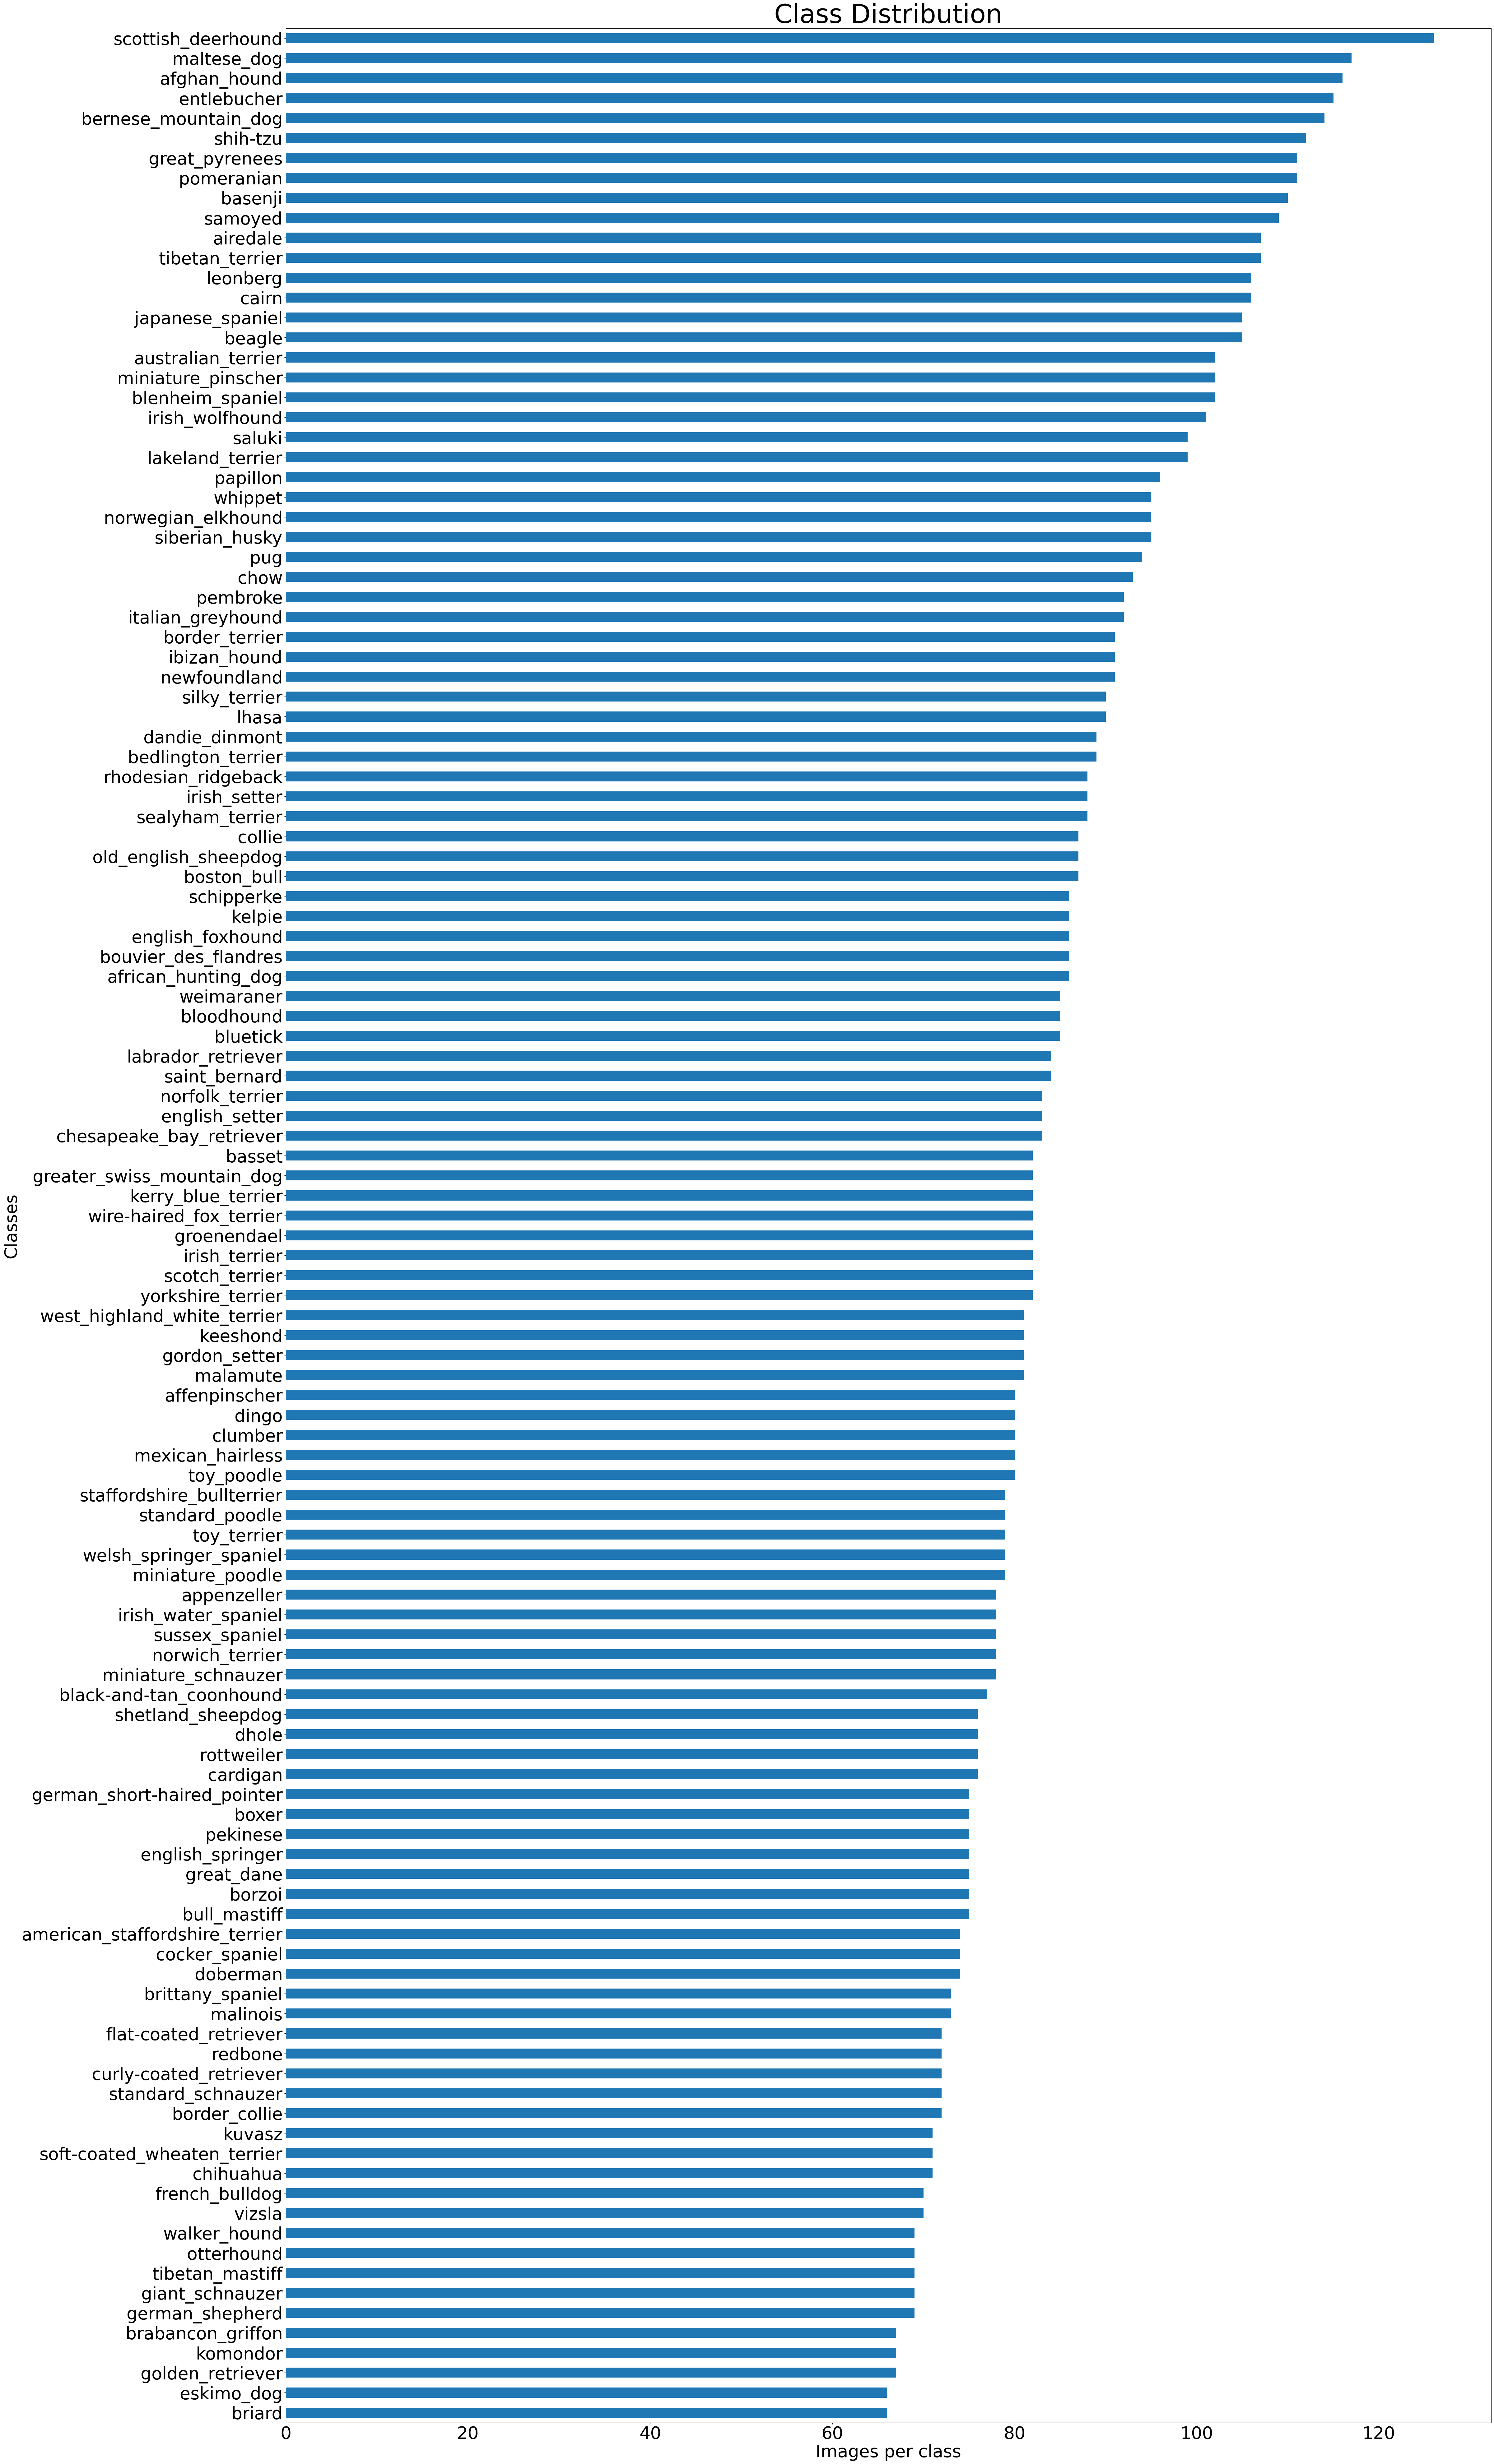

In [7]:
# Take a look at the class/breed distribution
ax=pd.value_counts(df['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

Selecting only Top 50 breed due to system limitation

In [10]:
top_25=list(df.breed.value_counts()[0:25].index)
top_25

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'blenheim_spaniel',
 'miniature_pinscher',
 'irish_wolfhound',
 'lakeland_terrier',
 'saluki',
 'papillon',
 'norwegian_elkhound',
 'whippet']

In [11]:
df_test2=df[df.breed.isin(top_25)]
df_test2.shape

(2668, 3)

Loading Images and converting it to pixel

In [12]:
img_pixel=np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in df_test2['img_path'].values.tolist()])
img_pixel.shape

(2668, 299, 299, 3)

Label encoding Dogs breed name for prediction

In [13]:
img_label=df_test2.breed
img_label=pd.get_dummies(df_test2.breed)
img_label.head()

,afghan_hound,airedale,australian_terrier,basenji,beagle,bernese_mountain_dog,blenheim_spaniel,cairn,entlebucher,great_pyrenees,...,miniature_pinscher,norwegian_elkhound,papillon,pomeranian,saluki,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier,whippet
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Final X,y Matrix for Deep learning prediction

In [14]:
X=img_pixel
y=img_label.values
print(X.shape)
print(y.shape)

(2668, 299, 299, 3)
(2668, 25)


Train test Split

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2134, 299, 299, 3)
(2134, 25)
(534, 299, 299, 3)
(534, 25)


Data pre-processing and data augmentation--
Image generator, to generate rotated,shifted,flipped images etc. To over come Translational invariance

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=32)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=32)

Defining Deep Learning Model

In [18]:
model=Sequential()

model.add(ZeroPadding2D((1,1),input_shape=(299,299,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(20,activation='softmax'))

model.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 301, 301, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 301, 301, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                        